# Chapter 17 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
from datetime import date

import matplotlib.pyplot as plt
import mlba
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series
%matplotlib inline

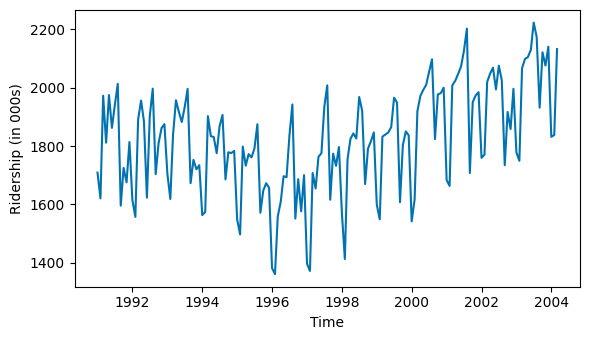

In [3]:
# load data and convert to time series
Amtrak_df = mlba.load_data('Amtrak.csv')
# convert the date information from a string to a datetime object
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,
    name='Ridership')
# define the time series frequency; here it is monthly
ridership_ts = ridership_ts.to_period('M')

# plot the series
fig, ax = plt.subplots(figsize=[6, 3.5])
plot_series(ridership_ts, ax=ax, markers=[None],
    x_label='Time', y_label='Ridership (in 000s)')
plt.tight_layout()
plt.show()

 
- The `pandas` command `to_datetime` is able to parse strings to a date in many different formats.
  See the documentation on how to specify the format string.
- The `to_period` method is used to specify that the values don't represent a particular points
  in time, but stand for the number of passengers in a given month (= period).
- The `plot_series` function is part of the `sktime` package and is a convenient way to 
  plot one or more time series data.

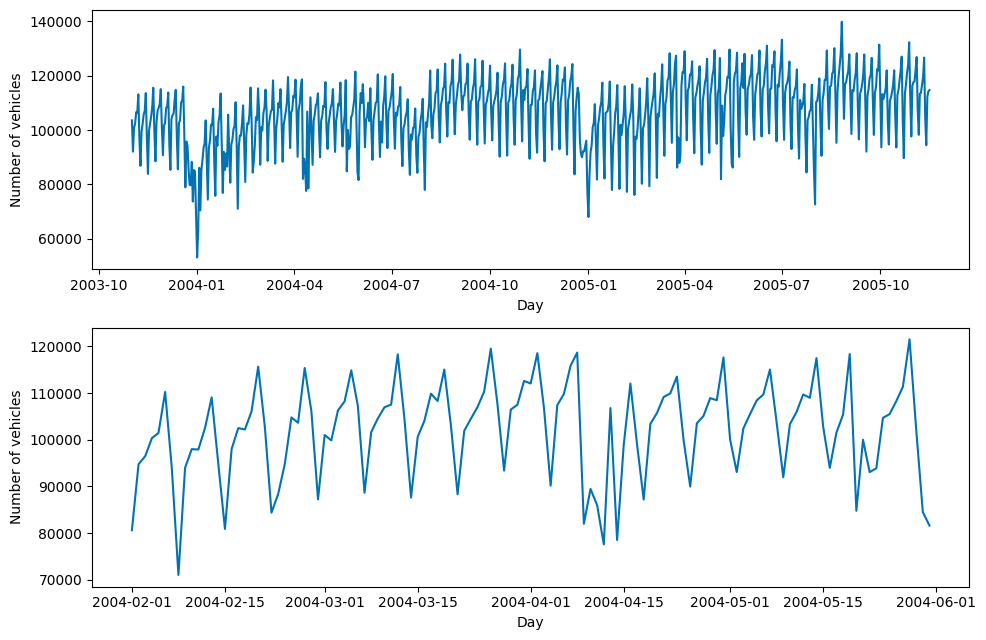

In [4]:
baregg_df = mlba.load_data('BareggTunnel.csv')

# convert the date information to a datetime object
baregg_df['Date'] = pd.to_datetime(baregg_df.Day, format='%d %b %Y')
vehicles_ts = pd.Series(baregg_df['Number of vehicles'].values, index=baregg_df.Date, name='Vehicles')
vehicles_ts = vehicles_ts.to_period('D')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6.5))
plot_series(vehicles_ts, ax=axes[0], markers=[None],
    x_label='Day', y_label='Number of vehicles')
plot_series(vehicles_ts['2004-02-01':'2004-05-31'], ax=axes[1], markers=[None],
    x_label='Day', y_label='Number of vehicles')
plt.tight_layout()
plt.show()

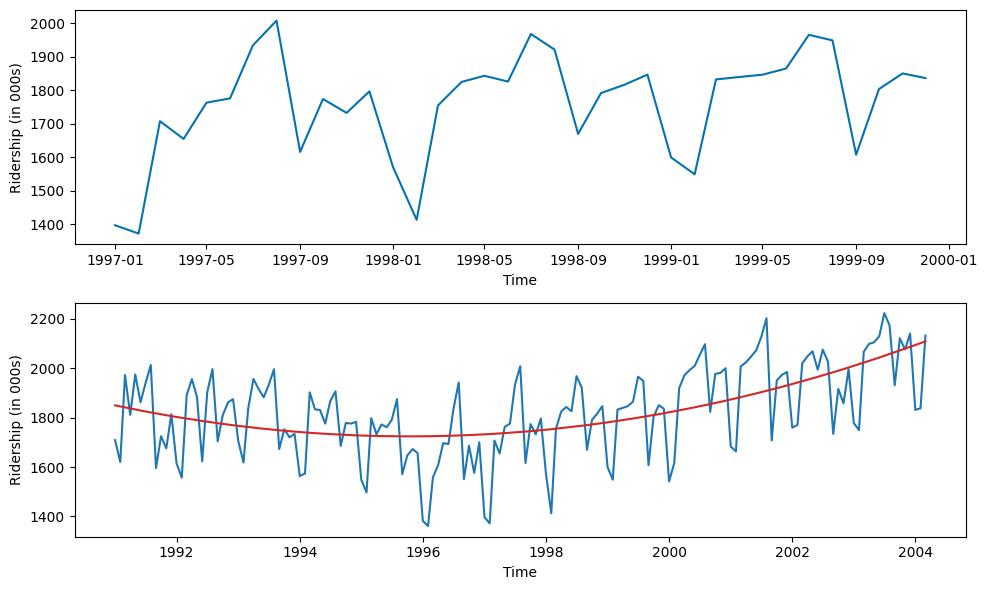

In [5]:
# create short time series from 1997 to 1999 using a slice
ridership_ts_3yrs = ridership_ts['1997':'1999']

# create a quadratic fit to the ridership data
forecaster = PolynomialTrendForecaster(degree=2)
forecaster.fit(ridership_ts)

# shorter and longer time series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
plot_series(ridership_ts_3yrs, ax=axes[0], markers=[None],
    x_label='Time', y_label='Ridership (in 000s)')
plot_series(ridership_ts, forecaster.predict(ridership_ts.index), ax=axes[1],
    x_label='Time', y_label='Ridership (in 000s)',
    colors=['C0', 'C3'], markers=[None, None])
plt.tight_layout()
plt.show()

 
- The `PolynomialTrendForecaster` fits a polynomial trend to the data.
  The degree of the polynomial is specified by the `degree` keyword argument; e.g. `degree=1` would fit 
  a linear trend, `degree=3` a cubic polynomial.

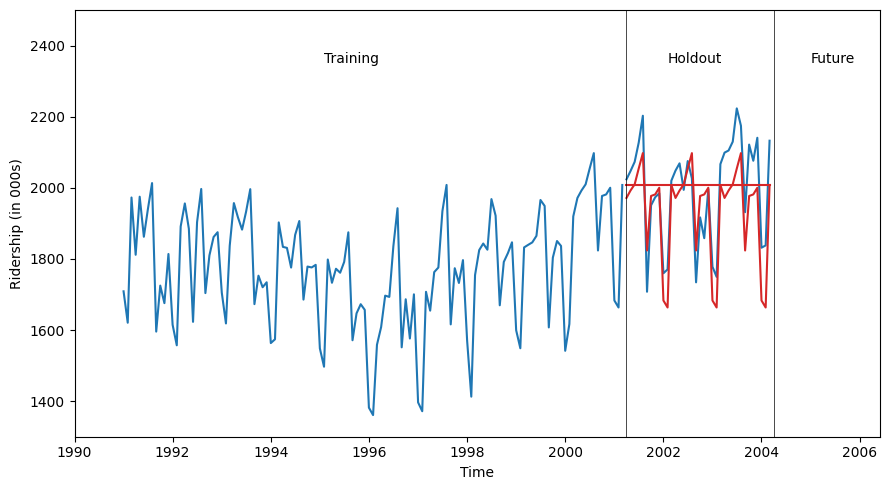

In [6]:
# partition the data
nHoldout = 36
train_ts, holdout_ts = temporal_train_test_split(ridership_ts, test_size=nHoldout)

# generate the naive and seasonal naive forecast
naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster.fit(train_ts)

seasonal_forecaster = NaiveForecaster(strategy="last", sp=12)
seasonal_forecaster.fit(train_ts)

# plot forecasts and actual in the training and holdout sets
fig, ax = plt.subplots(figsize=(9, 5))
plot_series(train_ts, holdout_ts,
    naive_forecaster.predict(holdout_ts.index),
    seasonal_forecaster.predict(holdout_ts.index),
    ax=ax, x_label='Time', y_label='Ridership (in 000s)',
    markers=[None, None, None, None], colors=['C0', 'C0', 'C3', 'C3'])
ax.set_xlim(date(1990, 1, 1), date(2006, 6, 1))
ax.set_ylim(1300, 2500)
ax.text(date(1995, 2, 1), 2350, 'Training')
ax.text(date(2002, 2, 1), 2350, 'Holdout')
ax.text(date(2005, 1, 1), 2350, 'Future')
ax.axvline(x=train_ts.index[-1], color='black', linewidth=0.5)
ax.axvline(x=holdout_ts.index[-1], color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

 Holdout set

In [7]:
pd.DataFrame({
    'Naive': mlba.regressionMetrics(y_true=holdout_ts,
        y_pred=naive_forecaster.predict(holdout_ts.index)),
    'Seasonal': mlba.regressionMetrics(y_true=holdout_ts,
        y_pred=seasonal_forecaster.predict(holdout_ts.index)),
}).round(4)

,Naive,Seasonal
ME,-14.7177,54.7296
RMSE,142.7551,95.6243
MAE,115.9234,84.0941
MPE,-1.2750,2.6528
MAPE,6.0214,4.2477


 Training set

In [8]:
pd.DataFrame({
    'Naive': mlba.regressionMetrics(y_true=train_ts,
        y_pred=naive_forecaster.predict(train_ts.index)),
    'Seasonal': mlba.regressionMetrics(y_true=train_ts,
        y_pred=seasonal_forecaster.predict(train_ts.index)),
}).round(4)

,Naive,Seasonal
ME,2.4310,12.5799
RMSE,167.4621,94.2991
MAE,124.2788,74.4440
MPE,-0.3432,0.5280
MAPE,7.2123,4.2552


## Naive forecasts for Amtrak ridership

<Axes: xlabel='Time', ylabel='Ridership'>

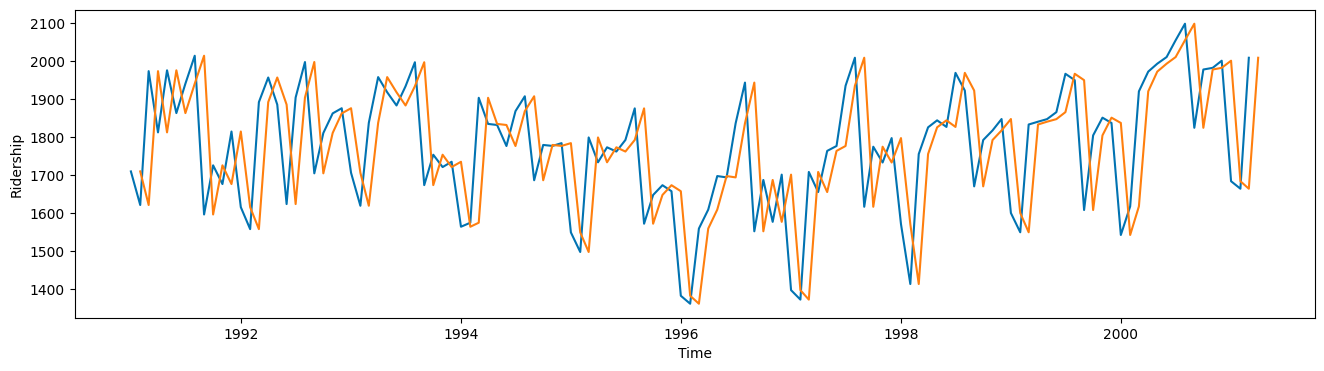

In [9]:
# naive_train_ts = pd.Series(train_ts[:-1].values, index=train_ts[1:].index)
naive_train_ts = train_ts.shift(1, freq='M')

_, ax = plot_series(train_ts, markers=[None],
                    x_label='Time', y_label='Ridership (in 000s)')
plot_series(naive_train_ts, ax=ax, markers=[None], colors=['C1'])

## Seasonal forecasts for Amtrak ridership

<Axes: xlabel='Time', ylabel='Ridership'>

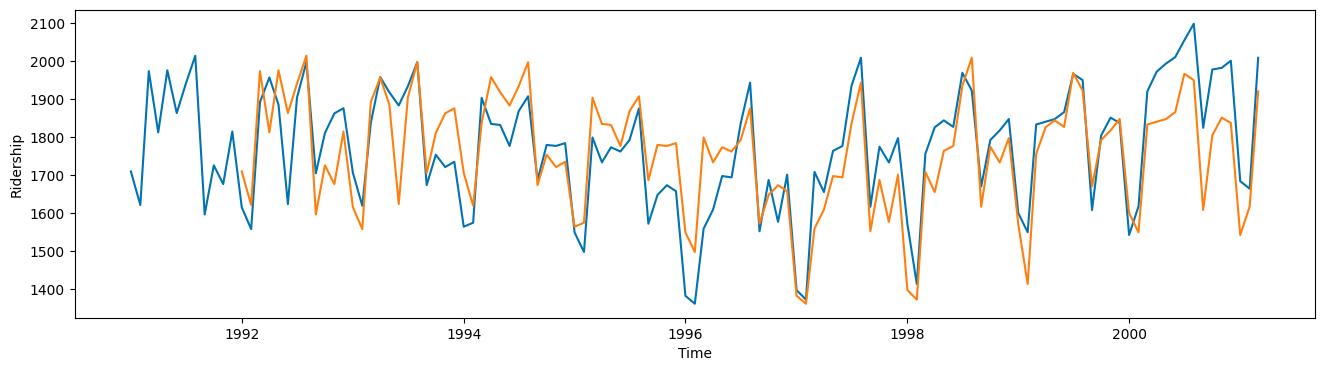

In [10]:
seasonal_train_ts = train_ts.shift(12, freq='M')
_, ax = plot_series(train_ts, markers=[None],
                    x_label='Time', y_label='Ridership (in 000s)')
plot_series(seasonal_train_ts[:-12], ax=ax, markers=[None], colors=['C1'])